In [1]:
import pandas as pd
import numpy as np

import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

from wordcloud import WordCloud

SELECT_YEAR = 2017

DATA_PATH = './data'
PLOT_PATH = './docs/plots/{}'.format(SELECT_YEAR)

In [2]:
# Data Read
data_file = '{}/{}_lattes.pkl.xz'.format(DATA_PATH, SELECT_YEAR)
%time df = pd.read_pickle(data_file, compression='xz')
print('{} docs shape'.format(df.shape))
df.head(5)

CPU times: user 84.7 ms, sys: 13.1 ms, total: 97.8 ms
Wall time: 107 ms
(8652, 5) docs shape


,id,titulo,clean,wct,wcc
79,104124422364023,Exploiting photo location and direction for cl...,"[exploit, photo, locat, direct, cluster, base,...",9,9
80,104124422364023,A gold-standard social media corpus for urban ...,"[gold, standard, social, media, corpus, urban,...",8,7
94,104124422364023,A Framework for Spatial Analytics using Hetero...,"[framework, spatial, analyt, use, heterogen, d...",9,7
140,105670521813027,Gene expression analysis in Musa acuminata dur...,"[gene, express, analysi, musa, acuminata, comp...",12,9
141,105670521813027,Mitogenome sequence accuracy using different e...,"[mitogenom, sequenc, accuraci, use, differ, el...",7,7


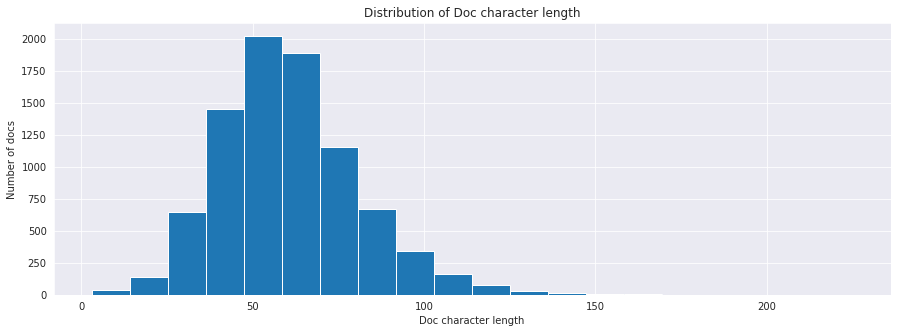

In [3]:
df['clean'] = df['clean'].apply(lambda x: ' '.join(x))

fig = plt.figure(figsize=(15, 5))

doc_lens = [len(d) for d in df.clean]

plt.hist(doc_lens, bins = 20)
plt.title('Distribution of Doc character length')
plt.ylabel('Number of docs')
plt.xlabel('Doc character length')
plt.show()

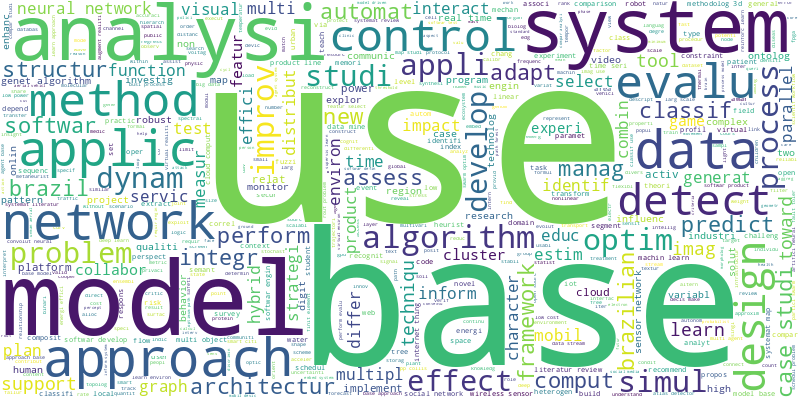

In [4]:
long_string = ' '.join(list(df.clean.values))

wordcloud = WordCloud(
                width=800, 
                height=400,
                background_color="white",
                max_words=5000,
                contour_width=3,
                contour_color='steelblue'
                ).generate(long_string)

wordcloud.to_image()

In [5]:
def get_top_ngram(corpus, gram, n=None):
    vec = CountVectorizer(ngram_range=(gram,gram), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def graph_ngram(gram, n=None):
    common_words = get_top_ngram(df.clean,gram,n)
    df_ngram = pd.DataFrame(common_words, columns = ['ngram' , 'count'])
    x = df_ngram['ngram']
    y = df_ngram['count']

    fig = plt.figure(figsize=(20,7))

    g = sns.barplot(x=x, y=y, order=x, palette='Blues_d')
    g.set_xticklabels(g.get_xticklabels(), rotation=90, fontsize=14)

    plt.yticks(fontsize=14)
    plt.xlabel('ngrams', fontsize=14)
    plt.ylabel('Docs', fontsize=14)
    plt.title('ngram={} - Top {} in docs'.format(gram,n), fontsize=17)
    del x, y, df_ngram

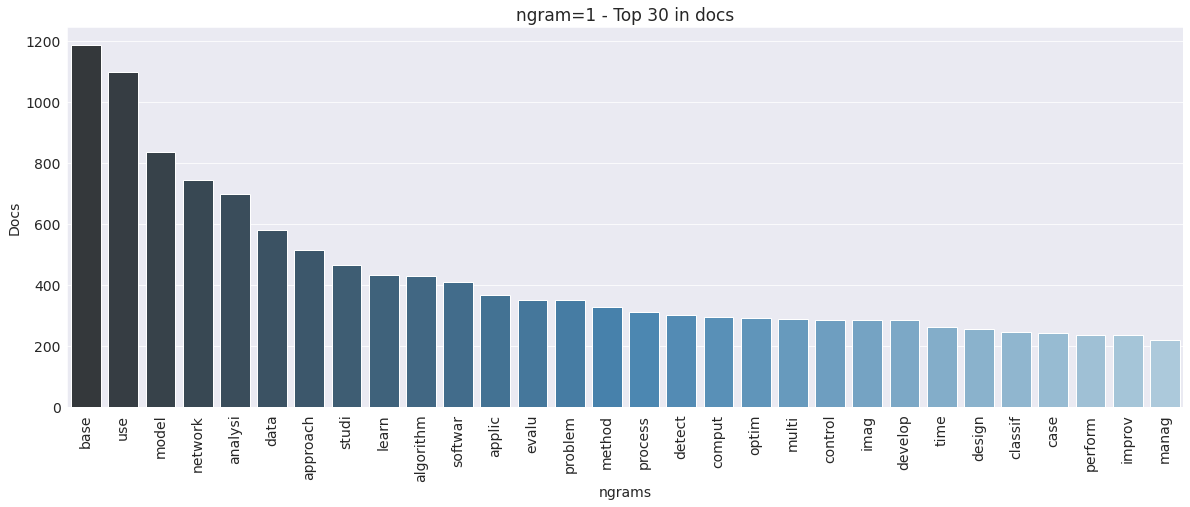

In [6]:
graph_ngram(1,30)

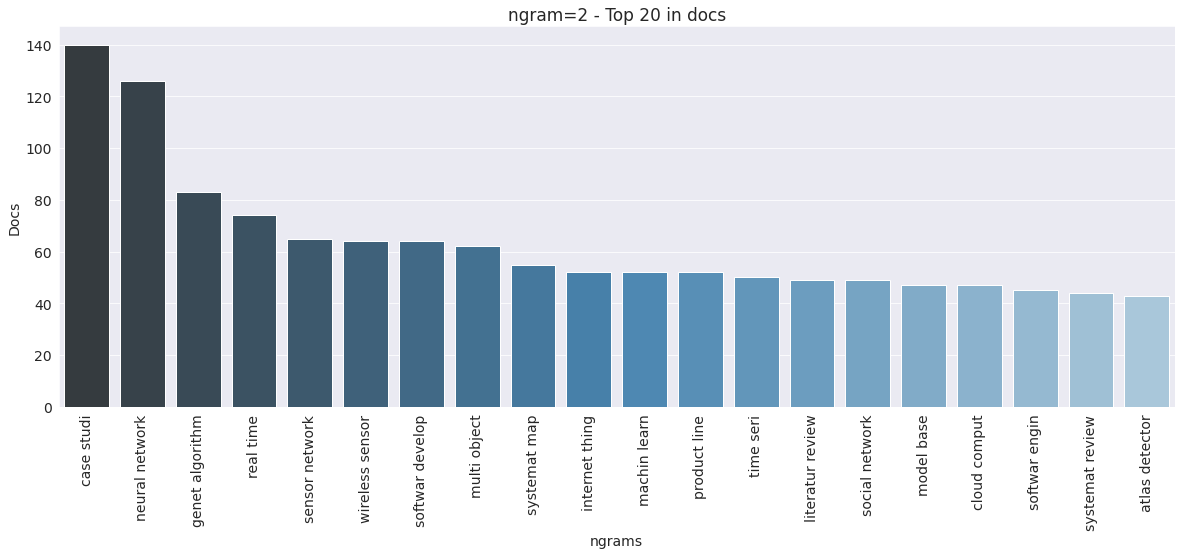

In [7]:
graph_ngram(2,20)

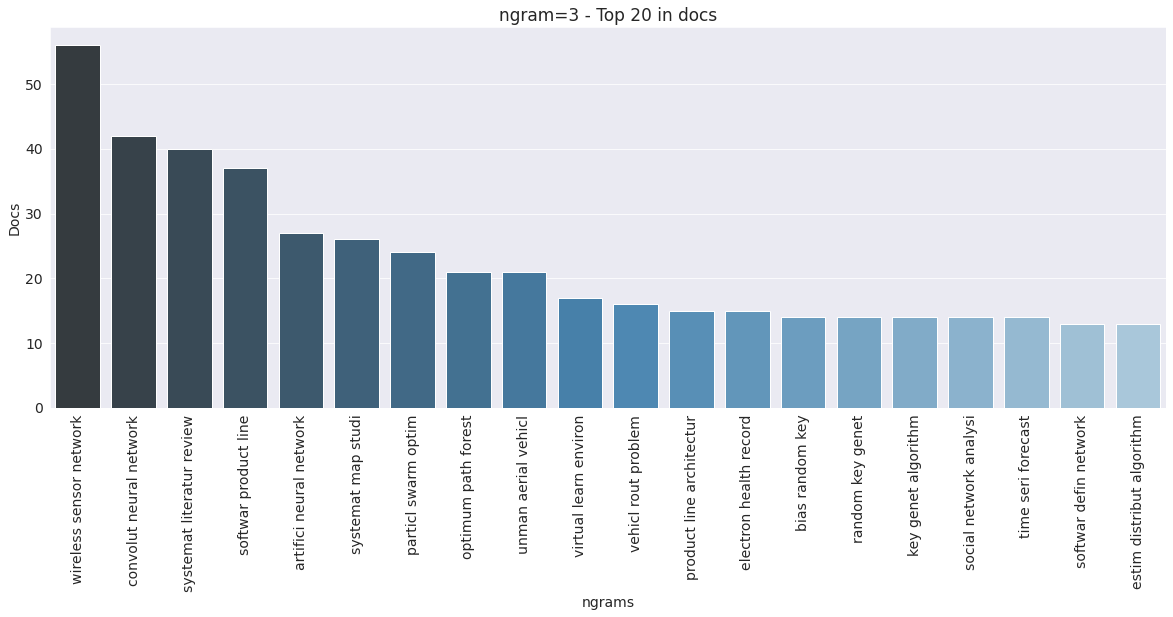

In [8]:
graph_ngram(3,20)

In [9]:
vectorizer = CountVectorizer(
    min_df=0.005,
    max_df=0.8,
    stop_words='english',
    lowercase=True,
    analyzer='word',
    token_pattern='[a-zA-Z0-9]{3,}',
    ngram_range=(1,3),
    max_features=5000)

data_vectorized = vectorizer.fit_transform(df.clean)

lda_model = LatentDirichletAllocation(
    n_components=20, # Number of topics
    learning_method='online',
    random_state=0,
    n_jobs = -1) # Use all available CPUs

lda_output = lda_model.fit_transform(data_vectorized)

In [10]:
ldavis = pyLDAvis.sklearn.prepare(lda_model, data_vectorized, vectorizer, mds='tsne')
pyLDAvis.save_html(ldavis, './docs/{}-LDA.html'.format(SELECT_YEAR))
pyLDAvis.display(ldavis)

In [11]:
print("Log likelihood: ", lda_model.score(data_vectorized))
print("Perplexity: ", lda_model.perplexity(data_vectorized))

Log likelihood:  -236798.02169309952
Perplexity:  391.72143482423434


In [12]:
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20)

df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['W'+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['T'+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,W0,W1,W2,W3,W4,W5,W6,W7,W8,W9,W10,W11,W12,W13,W14,W15,W16,W17,W18,W19
T0,network,manag,mobil,servic,inform,tool,smart,implement,health,diseas,technolog,novel,schedul,sequenc,detector,citi,access,atlas,base,wireless
T1,data,comput,architectur,cloud,network,neural,use,neural network,experi,open,composit,intellig,similar,resourc,driven,analyt,big,artifici,cloud comput,perspect
T2,imag,distribut,assess,effect,structur,visual,monitor,explor,text,program,qualiti,robot,manag,multi,influenc,project,genet,phase,base,state
T3,analysi,techniqu,high,graph,use,flow,pattern,heurist,deep,digit,rout,identifi,dimension,phase,databas,field,match,index,uncertainti,alloc
T4,improv,energi,social,network,video,tree,onlin,base,filter,optic,protocol,hevc,content,social network,rate,semi,scientif,algorithm,use,stream
T5,softwar,applic,process,dynam,new,brazil,educ,engin,awar,strategi,character,qualiti,context,industri,softwar develop,web,environ,defin,softwar engin,tool
T6,map,systemat,review,complex,relat,fuzzi,user,requir,recommend,literatur,sourc,logic,heterogen,correl,systemat map,particl,literatur review,cross,studi,augment
T7,base,approach,method,model,simul,code,differ,use,investig,element,distanc,emerg,scientif,workflow,collis,constraint,model base,base model,specif,ensembl
T8,algorithm,problem,parallel,genet,cluster,environ,collabor,use,identif,genet algorithm,linear,larg,internet,optim,thing,differenti,singl,electron,signal,general
T9,use,automat,effici,featur,generat,function,select,project,plan,behavior,classifi,water,fault,urban,point,evolut,diagnosi,respons,traffic,memori
